In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
from matplotlib import pyplot as plt


In [2]:
DIR_ = "D:/Drive/OneDrive/Documents/MIMIC"
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"

In [3]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [4]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [5]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [6]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [9]:
porter = PorterStemmer()

In [10]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

In [11]:
for i, text in enumerate(adm_notes['TEXT']):
   adm_notes.loc[i, 'TEXT'] = (' ').join(tokenize_stem(adm_notes['TEXT'][i]))

# Model
## Words, Train and Test

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Repartition data

In [13]:
df_train, df_test = train_test_split(adm_notes, test_size=0.2, random_state=42)

Subsample non-readmitted patients to match size of readmitted ones

In [14]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [15]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [16]:
print(df_train.shape)
print(df_test.shape)

(4724, 10)
(1202, 10)


Sparse Matrix with word count

# Recurrent Neural Network

In [17]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, SpatialDropout1D,GRU, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import tensorflow as tf

In [18]:
NUMBER_WORDS = 5000

tokenizer = Tokenizer(num_words=NUMBER_WORDS)
tokenizer.fit_on_texts(df_train['TEXT'])
sequences_train = tokenizer.texts_to_sequences(df_train['TEXT'])
sequences_test = tokenizer.texts_to_sequences(df_test['TEXT'])

X_train = pad_sequences(sequences_train, maxlen=NUMBER_WORDS)
X_test = pad_sequences(sequences_test, maxlen=NUMBER_WORDS)

In [19]:
y_train = to_categorical(df_train['READM_WITHIN_30'])
y_test = to_categorical(df_test['READM_WITHIN_30'])

In [20]:
adam = Adam(learning_rate=0.00001)

In [21]:
model = Sequential()
model.add(Embedding(X_train.shape[1], 64, input_length=X_train.shape[1]))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 64)          320000    
                                                                 
 conv1d (Conv1D)             (None, 4996, 64)          20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1249, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 439,618
Trainable params: 439,618
Non-trainable params: 0
__________________________________________________

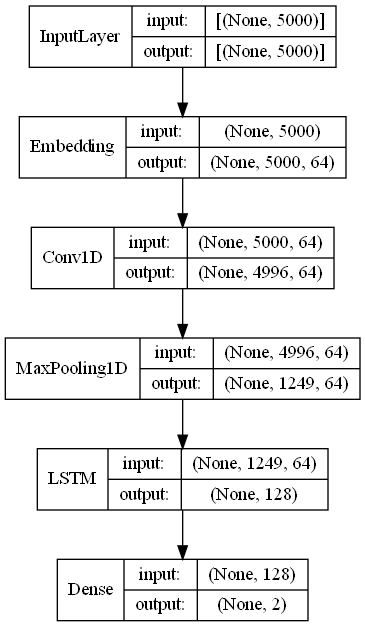

In [22]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=False)

In [23]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 64, validation_split=0.2)

Epoch 1/50
60/60 [==============================] - 801s 13s/step - loss: 0.6930 - accuracy: 0.5142 - val_loss: 0.6938 - val_accuracy: 0.4762
Epoch 2/50
60/60 [==============================] - 802s 13s/step - loss: 0.6928 - accuracy: 0.5189 - val_loss: 0.6938 - val_accuracy: 0.4762
Epoch 3/50
60/60 [==============================] - 1063s 18s/step - loss: 0.6926 - accuracy: 0.5155 - val_loss: 0.6940 - val_accuracy: 0.4751
Epoch 4/50
60/60 [==============================] - 848s 14s/step - loss: 0.6926 - accuracy: 0.5105 - val_loss: 0.6942 - val_accuracy: 0.4677
Epoch 5/50
60/60 [==============================] - 798s 13s/step - loss: 0.6923 - accuracy: 0.5115 - val_loss: 0.6943 - val_accuracy: 0.4677
Epoch 6/50
60/60 [==============================] - 800s 13s/step - loss: 0.6923 - accuracy: 0.5123 - val_loss: 0.6941 - val_accuracy: 0.4751
Epoch 7/50
60/60 [==============================] - 811s 14s/step - loss: 0.6921 - accuracy: 0.5136 - val_loss: 0.6940 - val_accuracy: 0.4751
Epoch

In [24]:
  print(model.metrics_names)
model.evaluate(X_test, y_test, batch_size=64)

['loss', 'accuracy']
19/19 [==============================] - 10s 522ms/step - loss: 0.6272 - accuracy: 0.6522


[0.6271787285804749, 0.6522462368011475]

In [25]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

y_test_raw = df_test['READM_WITHIN_30']

print(classification_report(y_test_raw, y_pred, digits=3))
print(roc_auc_score(y_test_raw, y_pred))

19/19 [==============================] - 11s 538ms/step
              precision    recall  f1-score   support

           0      0.623     0.770     0.689       601
           1      0.699     0.534     0.606       601

    accuracy                          0.652      1202
   macro avg      0.661     0.652     0.647      1202
weighted avg      0.661     0.652     0.647      1202

0.6522462562396006


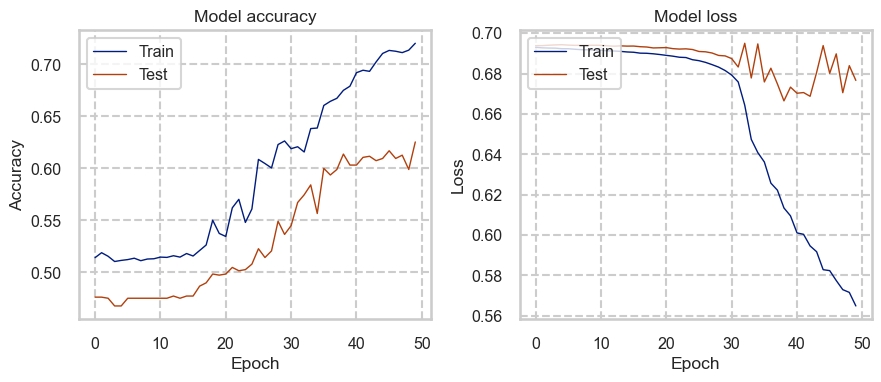

In [26]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()